# Burnt Area Analysis
## Burnt Area Daily NRT Incremental Product / Monthly Composite / Yearly Composite - Europe, Sentinel-3

In [1]:
# we will need some imports, let's get them out of the way
from affine import Affine
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import math

import rasterio.windows
from rasterio import features
from rasterio.enums import MergeAlg, Resampling
from rasterio.plot import show
from rasterio.vrt import WarpedVRT

### Example

The easiest way to work with the data is using the [OGC Feature API](https://github.com/opengeospatial/ogcapi-features) to query the [monthly](https://geoservice.dlr.de/eoc/ogc/features/collections/demo:BURNTAREA_S3_EFR_P1D) and [yearly](https://geoservice.dlr.de/eoc/ogc/features/collections/demo:BURNTAREA_S3_EFR_P1Y) products.

You can use filtering to query the data serverside. For example we can query all monthly products with a `confidence` of over `95%` and a `burn_severity` of motr than `0.2` (more positive values indicate higher burn severities):
https://geoservice.dlr.de/eoc/ogc/features/collections/demo:BURNTAREA_S3_EFR_P1M/items?f=application%2Fgeo%2Bjson&limit=1&filter=confidence_total>95%20AND%20burn_severity>0.2

However, let's start with some analysis. First we will need some auxiliary data (the state territory of Greece).

#### Auxiliary data: Load global country boundaries from Natural Earth (low resolution)

<Axes: >

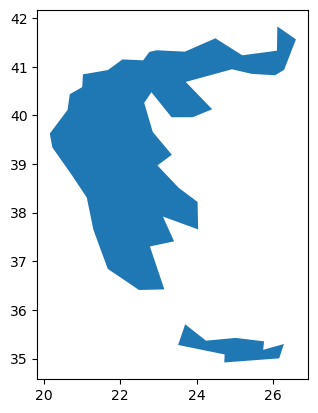

In [2]:
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))  # be aware that this is low-resolution and just used for demo purposes
greece = countries[countries["iso_a3"] == "GRC"]
greece.plot()

In [3]:
# get the bounds, we will use them to query data with later on
minx, miny, maxx, maxy = greece.total_bounds

#### Exploration with Geopandas

Let's get all the burntareas of Greece in the last years.

In [4]:
# filter the area of Greece directly

yearly_url = f"https://geoservice.dlr.de/eoc/ogc/features/collections/demo:BURNTAREA_S3_EFR_P1Y/items?f=application%2Fjson&bbox={minx},{miny},{maxx},{maxy}"

yearly_grc = gpd.read_file(yearly_url)  

# drop some columns we do not need later on, you can also do this directly
yearly_grc.drop(["id", "t_stamp_end", "region", "name"], axis=1, inplace=True)  

yearly_grc.head()

,first_seen,burn_severity,confidence_total,t_stamp_start,area_ha,geometry
0,2017-09-15 08:57:20+00:00,-0.160346,87.26,2017-01-01 00:00:00+00:00,341.999600,"POLYGON ((22.31814 39.41631, 22.31867 39.41901..."
1,2017-11-02 08:11:13+00:00,-0.084798,88.98,2017-01-01 00:00:00+00:00,8.999999,"POLYGON ((22.09033 40.04062, 22.09086 40.04332..."
2,2017-08-30 09:09:18+00:00,-0.012951,90.61,2017-01-01 00:00:00+00:00,9.000000,"POLYGON ((26.23716 39.86711, 26.23786 39.86977..."
3,2017-08-30 09:09:18+00:00,-0.212084,86.09,2017-01-01 00:00:00+00:00,9.000000,"POLYGON ((22.32408 39.39330, 22.32461 39.39600..."
4,2017-12-12 09:13:02+00:00,-0.007912,90.73,2017-01-01 00:00:00+00:00,9.000000,"POLYGON ((22.25734 39.03393, 22.25786 39.03663..."


- `burn_severity`: This column gives a measure of the loss in vegetation fitness for each burnt area, on a scale between -2 and +2. It is calculated by determining the Normalized Difference Vegetation Index ([NVDI](https://de.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index)) for two points in time, before and after the fire (pre/post). The post fire value is subtracted from the pre fire value (differential NDVI), so that the more positive the result gets, the higher is the loss in vegetation fitness. The column represents the mean value of the totality of differential values within the burnt area perimeter.

- `confidence`: The value makes a statement about the estimated accuracy of the burnt area perimeter. It incorporates the severity of the burning together with the number of corresponding active fire measurements, with the result given in percent.

- `first seen`: This represents the exact point in time when the first burning inside the final perimeter was detected.

- `t_stamp_start` / `t_stamp_stop`: These columns are used to set time range for the query of the whole product. 

- `geometry`: This is the perimeter of the burnt area in geographic projection (WGS84), provided in the Well-Known Text (WKT) notation.

- `area_ha`: This is the exact size of the extent of each burnt area, giben in hectares. While the geometries are provided in WGS84 (latitude/longitude), the determination of this value is based on the Lambert Azimuthal (LAEA) projection. 

Let's see how much it burnt per year.
Note again that we used a low-resolution bounding box of Greece, so don't worry about how correct these numbers are.

In [5]:
yearly_grc_ha = yearly_grc.groupby(["t_stamp_start"]).area_ha.sum().reset_index()  # group by year and sum all areas

yearly_grc_ha.t_stamp_start = yearly_grc_ha.t_stamp_start.values.astype('datetime64[D]')  # this is just for better plotting
yearly_grc_ha.head()

,t_stamp_start,area_ha
0,2017-01-01,200700.860779
1,2018-01-01,126189.224045
2,2019-01-01,147717.111014
3,2020-01-01,111564.161123
4,2021-01-01,198513.474203


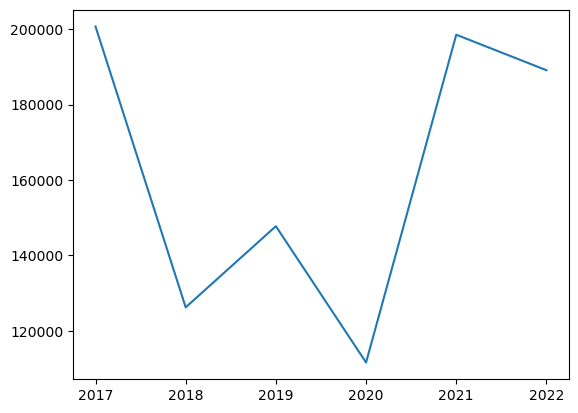

In [6]:
# let's have a look
years = yearly_grc_ha.t_stamp_start.dt.year
plt.xticks(range(math.floor(min(years)), math.ceil(max(years))+1))
plt.plot(years, yearly_grc_ha.area_ha)

In [7]:
# alright, let's take a closer look at 2021. We start by filtering the dataframe again:

grc_2021 = yearly_grc[yearly_grc["t_stamp_start"] == "2021-01-01T00:00:00+00:00"]
grc_2021.head()

,first_seen,burn_severity,confidence_total,t_stamp_start,area_ha,geometry
2596,2021-12-26 07:52:50+00:00,-0.176960,86.89,2021-01-01 00:00:00+00:00,9.000001,"POLYGON ((26.42977 41.23592, 26.43052 41.23857..."
2600,2021-09-16 08:11:35+00:00,-0.037103,90.07,2021-01-01 00:00:00+00:00,207.000150,"POLYGON ((20.33609 40.64541, 20.33563 40.64271..."
2601,2021-03-04 09:33:42+00:00,-0.032196,90.18,2021-01-01 00:00:00+00:00,62.999805,"POLYGON ((21.10510 40.31302, 21.10608 40.31842..."
2602,2021-10-30 08:12:46+00:00,-0.022222,90.40,2021-01-01 00:00:00+00:00,9.000000,"POLYGON ((24.13898 41.00044, 24.14245 40.99989..."
2606,2021-03-04 08:32:08+00:00,-0.054673,89.67,2021-01-01 00:00:00+00:00,9.000000,"POLYGON ((20.31688 40.63660, 20.31734 40.63930..."


<Axes: >

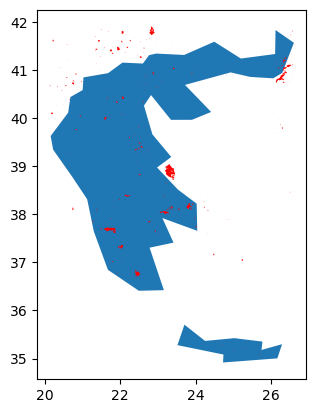

In [8]:
# that's how it looks like, remember that the border is very low-resolution and we used a bounding box. E.g. Euboea is missing in the background map, but there was a huge fire.

base = greece.plot()
grc_2021.plot(ax=base, color="red", )

As you can see, a lot has been burnt. Often this is due to e.g. agricultural burning and we can filter them out using landcover data.

#### Auxiliary data: Download ESA World cover data for Greece

We will take the boundary coordinates of Greece to read in the landcover data for Greece in a ~300 meter resolution, like our burnt area data.

In [9]:
# Output image transform with the resolution of ~300m.

xres = 0.002777777777777777884
yres = -0.002777777777777777884

dst_width = int((maxx - minx) / xres) 
dst_height = abs(int((maxy - miny) / yres))
dst_transform = Affine(xres, 0.0, minx, 
                       0.0, yres, maxy)

# Read in and warp the LC data - this might take a bit

vrt_options = {
    "crs": yearly_grc.crs,
    "transform": dst_transform,
    "height": dst_height, 
    "width": dst_width,
    "resampling": Resampling.nearest,
}

with rasterio.Env(AWS_NO_SIGN_REQUEST="YES"):
    with rasterio.open("/vsis3/esa-worldcover/v100/2020/ESA_WorldCover_10m_2020_v100_Map_AWS.vrt") as ds:
        with WarpedVRT(ds, **vrt_options) as vrt:
            window = rasterio.windows.from_bounds(*greece.total_bounds, transform=vrt.transform)
            lulc_band = vrt.read(1, window=window)

Now that we have the LC as raster we also convert our burnt area product into a raster so we can combine the data more easily

In [10]:
# get the value we want per pixel in int16

burntareas_geom_value = ((geom, int(value)) for geom, value in zip(grc_2021.geometry, round(grc_2021["burn_severity"] * 100,0)))

# rasterize it
grc_2021_arr = features.rasterize(
    burntareas_geom_value,
    out_shape=lulc_band.shape,
    transform=dst_transform,
    all_touched=True,
    fill=-5,  # background value
    merge_alg=MergeAlg.replace,
    dtype=np.int16,
)

<Axes: >

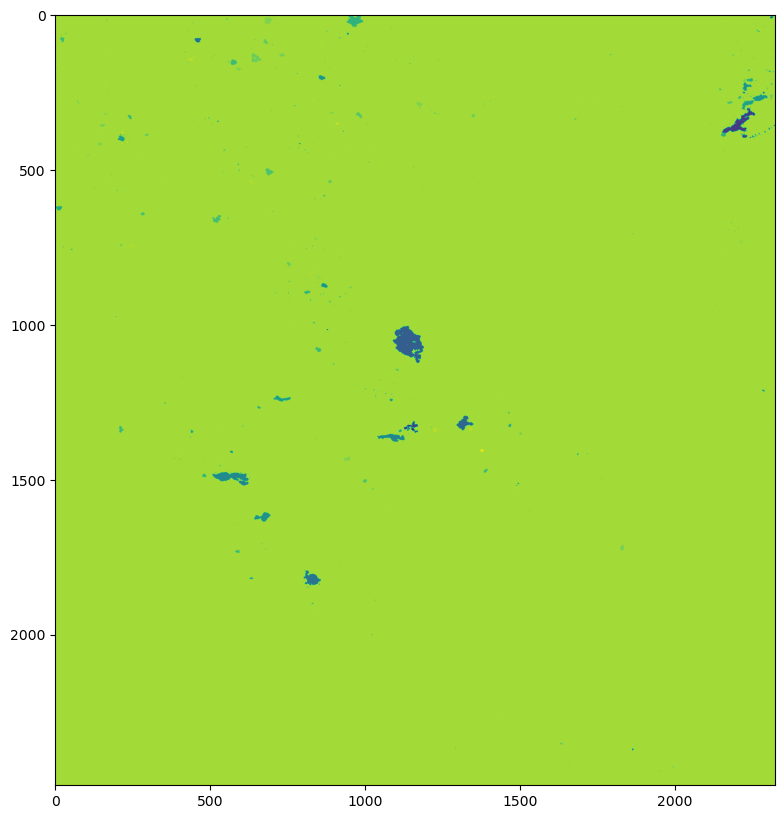

In [11]:
# let's have a look, note the difference in burn severity. The raster is zoomed to the burnt area extent.

fig, ax = plt.subplots(1, figsize = (10, 10))
show(grc_2021_arr, ax = ax)
plt.gca()

We use the LC to filter out any cropland from the burnt area we detected. Cropland has a value of 40 in the LC dataset we are using.

<Axes: >

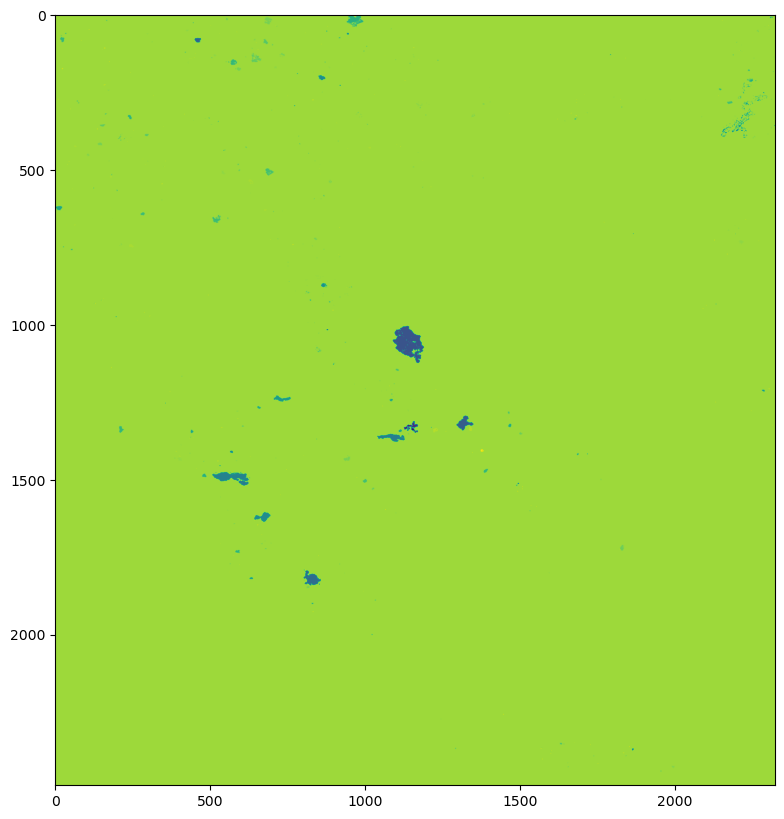

In [12]:
 # create a filter
crop = lulc_band == 40

# set to background value
grc_2021_arr[crop] = -5

# let's have a look again, note that the burntarea in the north east was mainly agriculture burning
fig, ax = plt.subplots(1, figsize = (10, 10))
show(grc_2021_arr, ax = ax)
plt.gca()